In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from jsindy.kernels import ConstantKernel,ScalarMaternKernel

In [2]:
exp_data = LorenzExp

In [23]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = 8.
dt = 0.12
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)
kernel = (
        ConstantKernel(variance = 5.)
        +ScalarMaternKernel(p = 5,variance = 10.)
    )   
trajectory_model = DataAdaptedRKHSInterpolant(kernel = kernel)
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,
                                           solver_settings=optsettings,
                                           fixed_colloc_weight=250.),
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(8.65377059, dtype=float64), 'data_weight': Array(0.11554321, dtype=float64), 'colloc_weight': 250.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 2.733e+07, gradnorm = 1.046e+10, alpha = 5.0, improvement_ratio = 0.766
Iteration 1, loss = 1.395e+07, gradnorm = 2.442e+10, alpha = 5.0, improvement_ratio = 0.4896
Iteration 2, loss = 3.876e+06, gradnorm = 2.68e+10, alpha = 5.0, improvement_ratio = 0.7222
Iteration 3, loss = 3.468e+06, gradnorm = 1.834e+10, alpha = 45.56, improvement_ratio = 0.1051
Iteration 4, loss = 4.777e+04, gradnorm = 4.026e+10, alpha = 37.97, improvement_ratio = 0.9863
Iteration 5, loss = 977.4, gradnorm = 3.165e+09, alpha = 31.64, improvement_ratio = 0.983
Iteration 200, loss = 98.7, gradnorm = 1.587e+06, alpha = 0.4975, improvement_ratio = 0.7674
Iteration 400, loss = 94.62, gradnorm = 1.977e+04, alpha = 1.196e-14, improvement_ratio = 0.998
Iteration 600, loss = 94.49, gradnorm = 1.542e+04, alpha = 8.333e-17, improvement_ratio = 1.001
Iteration 800, loss = 94.4, gradnorm = 2.682e+04, alpha = 8.333e-17, improvement_ratio = 1.0
Iteration 1000, loss = 94.29, gradnorm = 6.998e+03, alpha = 8.333

In [24]:
model.print()

(x)' = 13.449 x + -0.740 x z + 0.252 y z
(y)' = 2.283 1 + 19.064 x + 3.059 y + 0.710 z + -1.516 x^2 + 2.434 x y + -0.866 x z + -1.055 y^2
(z)' = 2.919 1 + -2.601 z + 1.323 x y + -0.365 y^2


In [25]:
metrics

{'coeff_mets': {'precision': 0.4,
  'recall': 0.8571428571428571,
  'f1': 0.5454545454545454,
  'coeff_rel_l2': 0.8804527797401707,
  'coeff_rmse': 5.068306909211719,
  'coeff_mae': 1.9747025871039334},
 'data_mets': {'mse': Array(712.66848933, dtype=float64),
  'rmse': np.float64(26.69585153778465),
  'mae': np.float64(15.71648804411319),
  'max_abs_error': np.float64(181.67268425140503),
  'normalized_mse': Array(0.18318902, dtype=float64),
  'relative_l2_error': np.float64(0.4279376320353742)}}

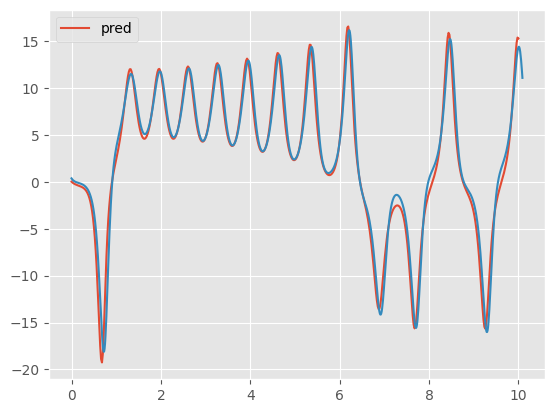

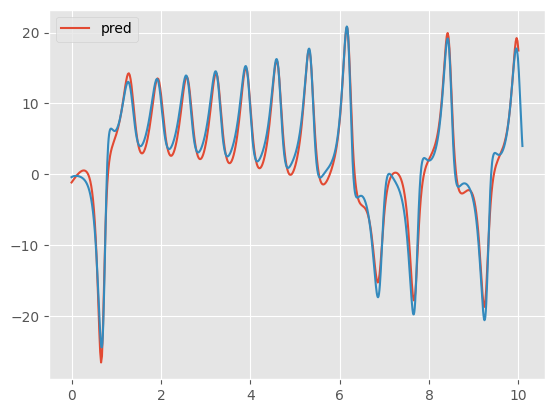

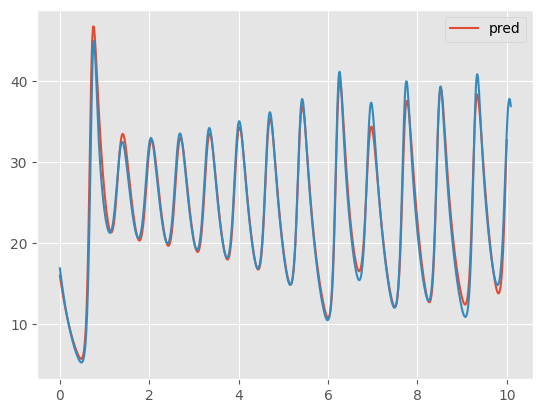

In [26]:
t_grid = jnp.linspace(0,10,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i])
    plt.legend()
    plt.show()

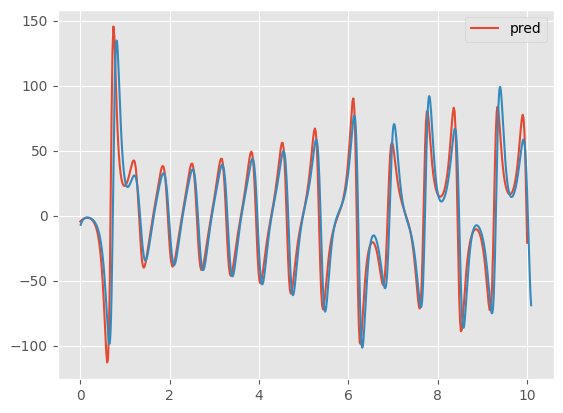

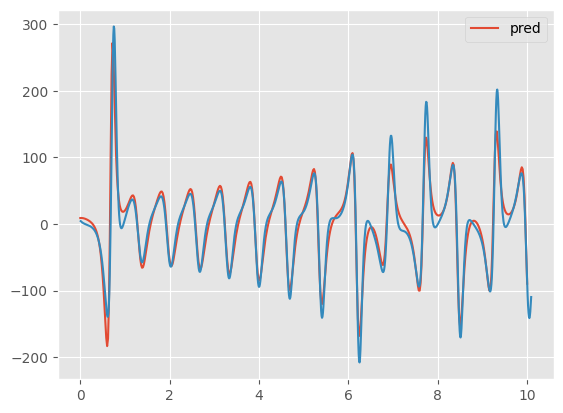

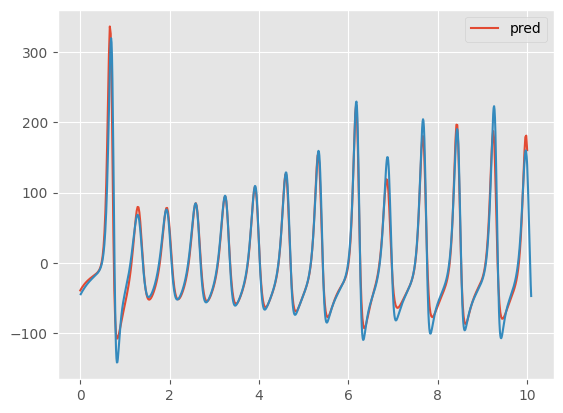

In [27]:
t_grid = jnp.linspace(0,10,500)
xdot_pred = model.traj_model.derivative(t_grid,model.z)

h = expdata.t_true[1]-expdata.t_true[0]
for i in range(3):
    plt.plot(t_grid,xdot_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true[1:],jnp.diff(expdata.x_true[:,i])/h)
    plt.legend()
    plt.show()

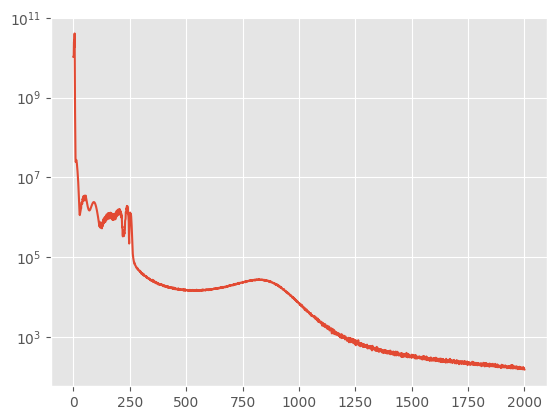

In [28]:
plt.plot(model.opt_result[0].gradnorm)
plt.yscale('log')

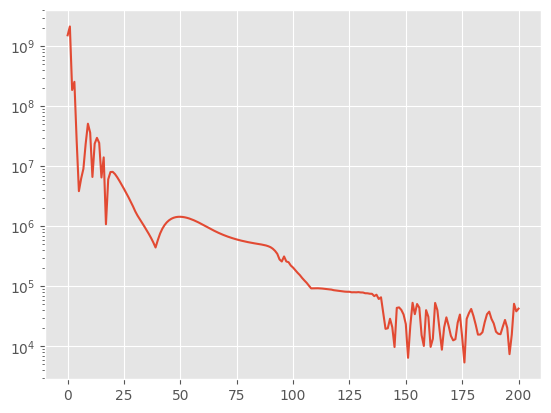

In [36]:
plt.plot(jnp.array(model.opt_result[1].history['gnorms'])[0])
plt.yscale('log')

In [30]:
t_grid = jnp.linspace(0,10,2000)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3
pysindy_optimizer = STLSQ(threshold = 0.1,alpha =0.01)
pysindy_optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(pysindy_optimizer.coef_).T

model.print(refit_theta)

(x)' = 13.449 x + -0.740 x z + 0.252 y z
(y)' = 2.283 1 + 19.064 x + 3.059 y + 0.710 z + -1.516 x^2 + 2.434 x y + -0.866 x z + -1.055 y^2
(z)' = 2.919 1 + -2.601 z + 1.323 x y + -0.365 y^2


In [32]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.18395811, dtype=float64)